### Importamos librerias y abrimos el dataset limpio

In [1]:
!pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as st
import sklearn as sk
import joblib

from sklearn import tree
from sklearn.tree import export_text, DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, confusion_matrix, classification_report, make_scorer
from sklearn.preprocessing import OneHotEncoder

In [3]:
# https://drive.google.com/file/d/1yD6KxeeZYpSgohxuI-kxn71C0NSkHVB3/view?usp=share_link -- 1ro
# https://drive.google.com/file/d/1IPS_Hy9GVRNGBonA0R9ywIyaS5jRI6OJ/view?usp=sharing --2do
# https://drive.google.com/file/d/1IOu_aCEWfmb-vsY7bxB1EC4i7ZCKOLhn/view?usp=share_link
# https://drive.google.com/file/d/1N_PQUWOXO7PfNegr8fJOB_U5eeZIzGJn/view?usp=sharing

dataset = pd.read_csv("https://drive.google.com/uc?export=download&id=1N_PQUWOXO7PfNegr8fJOB_U5eeZIzGJn")
dataset.isnull().sum()

hotel                             0
arrival_date_month                0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
reserved_room_type                0
assigned_room_type                0
deposit_type                      0
customer_type                     0
id                                0
lead_time                         0
arrival_date_year                 0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
booking_changes                   0
agent                             0
company                           0
days_in_waiting_list              0
adr                         

In [4]:
dataset.head()

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,...,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,is_canceled
0,City Hotel,September,BB,USA,Online TA,TA/TO,D,D,No Deposit,Transient,...,0,0,0,9.0,0.0,0,115.5,0,1,1
1,Resort Hotel,October,BB,PRT,Groups,Direct,A,A,No Deposit,Transient,...,0,0,0,0.0,0.0,0,42.0,1,0,0
2,City Hotel,October,BB,CHE,Online TA,TA/TO,F,F,No Deposit,Transient,...,0,0,0,9.0,0.0,0,229.0,0,2,0
3,City Hotel,December,BB,PRT,Groups,TA/TO,A,A,Non Refund,Transient,...,0,0,0,154.0,0.0,0,75.0,0,0,1
4,City Hotel,March,BB,FRA,Offline TA/TO,TA/TO,A,A,No Deposit,Transient-Party,...,0,0,0,20.0,0.0,0,75.0,0,1,0


In [5]:
dataset.nunique()

hotel                                 2
arrival_date_month                   12
meal                                  5
country                             150
market_segment                        7
distribution_channel                  5
reserved_room_type                    9
assigned_room_type                   11
deposit_type                          3
customer_type                         4
id                                60993
lead_time                           467
arrival_date_year                     3
arrival_date_week_number             53
arrival_date_day_of_month            31
stays_in_weekend_nights               9
stays_in_week_nights                 23
adults                               12
children                              4
babies                                3
is_repeated_guest                     2
previous_cancellations               15
previous_bookings_not_canceled       31
booking_changes                       5
agent                               296


In [6]:
dataset.columns.to_list()

['hotel',
 'arrival_date_month',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'customer_type',
 'id',
 'lead_time',
 'arrival_date_year',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'agent',
 'company',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'is_canceled']

### Formateamos la columna `arrival_date_month` para que sea numérica

In [7]:
# verifico que los meses esten en camelcase
dataset['arrival_date_month'].unique()

array(['September', 'October', 'December', 'March', 'November', 'July',
       'June', 'April', 'August', 'February', 'January', 'May'],
      dtype=object)

In [8]:
# Defino un dicc con los meses en camelcase
meses_dict = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
              'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}

# Reemplazar los valores en el dataframe
dataset['arrival_date_month'] = dataset['arrival_date_month'].replace(meses_dict)
dataset['arrival_date_month'].unique()

array([ 9, 10, 12,  3, 11,  7,  6,  4,  8,  2,  1,  5])

### Limpiamos el Dataset de test

In [9]:
# https://drive.google.com/file/d/1JWqglsFAU_e8acYK-1XOY5nH8iNgiLP4/view?usp=share_link

dataset_test = pd.read_csv("https://drive.google.com/uc?export=download&id=1JWqglsFAU_e8acYK-1XOY5nH8iNgiLP4")
dataset_test.shape

(26535, 32)

In [10]:
dataset_test.isna().sum()

hotel                                 0
lead_time                             0
arrival_date_year                     0
arrival_date_month                    0
arrival_date_week_number              0
arrival_date_day_of_month             0
stays_in_weekend_nights               0
stays_in_week_nights                  0
adults                                0
children                              0
babies                                0
meal                                  0
country                              95
market_segment                        0
distribution_channel                  0
is_repeated_guest                     0
previous_cancellations                0
previous_bookings_not_canceled        0
reserved_room_type                    0
assigned_room_type                    0
booking_changes                       0
deposit_type                          0
agent                              3363
company                           25218
days_in_waiting_list                  0


In [11]:
dataset_test.meal.unique()

array(['BB', 'HB', 'SC', 'Undefined', 'FB'], dtype=object)

Limpiamos el dataset de test para poder trabajar con los datos

In [12]:
media=round(dataset_test['children'].mean())

dataset_test.children.fillna(media, inplace=True)

dataset_test.country.fillna('unknown', inplace=True)

dataset_test.agent.fillna(0, inplace=True)

dataset_test.company.fillna(0, inplace=True)

dataset_test.loc[dataset_test['meal'] == 'Undefined', 'meal'] = 'No meal'

dataset_test['arrival_date_month'] = dataset_test['arrival_date_month'].replace(meses_dict)

dataset_test.drop(columns=['reservation_status', 'reservation_status_date'], inplace=True)

In [13]:
# dataset_test.country.value_counts().sort_values(ascending=False).head(10).index.to_list()

available_countries = {'PRT', 'GBR', 'FRA', 'ESP', 'DEU', 'ITA', 'IRL', 'BRA', 'BEL', 'USA'}

dataset['country'] = np.where(dataset['country'].isin(available_countries), dataset['country'], 'otro')

dataset_test['country'] = np.where(dataset_test['country'].isin(available_countries), dataset_test['country'], 'otro')

In [14]:
availables_assigned_room_type = {'A', 'D', 'E', 'F', 'G', 'C', 'B', 'H', 'I', 'K'}

dataset['assigned_room_type'] = np.where(dataset['assigned_room_type'].isin(availables_assigned_room_type), dataset['assigned_room_type'], 'otro')

dataset_test['assigned_room_type'] = np.where(dataset_test['assigned_room_type'].isin(availables_assigned_room_type), dataset_test['assigned_room_type'], 'otro')

In [15]:
availables_reserved_room_type = {'A', 'D', 'E', 'F', 'G', 'C', 'B', 'H'}

dataset['reserved_room_type'] = np.where(dataset['reserved_room_type'].isin(availables_reserved_room_type), dataset['reserved_room_type'], 'otro')

dataset_test['reserved_room_type'] = np.where(dataset_test['reserved_room_type'].isin(availables_reserved_room_type), dataset_test['reserved_room_type'], 'otro')

In [16]:
# TODO: Imputar de otra manera
dataset.loc[dataset['distribution_channel'] == 'Undefined', 'distribution_channel'] = 'TA/TO'

dataset.distribution_channel.value_counts()

TA/TO        51094
Direct        6678
Corporate     3132
GDS             89
Name: distribution_channel, dtype: int64

In [17]:
# TODO: Imputar de otra manera
dataset.loc[dataset['market_segment'] == 'Undefined', 'market_segment'] = 'Online TA'

dataset.market_segment.value_counts()

Online TA        28918
Offline TA/TO    12198
Groups           11300
Direct            5663
Corporate         2452
Complementary      350
Aviation           112
Name: market_segment, dtype: int64

In [18]:
print(dataset.reserved_room_type.value_counts().sort_values(ascending=False).head(10).index.to_list())
print(dataset_test.reserved_room_type.value_counts().sort_values(ascending=False).head(10).index.to_list())

['A', 'D', 'E', 'F', 'G', 'C', 'B', 'H', 'otro']
['A', 'D', 'E', 'F', 'G', 'B', 'C', 'H', 'otro']


In [19]:
dataset_test.country.unique()

array(['PRT', 'FRA', 'DEU', 'otro', 'GBR', 'ITA', 'IRL', 'USA', 'ESP',
       'BEL', 'BRA'], dtype=object)

In [20]:
dataset.country.unique()

array(['USA', 'PRT', 'otro', 'FRA', 'GBR', 'DEU', 'ESP', 'IRL', 'ITA',
       'BEL', 'BRA'], dtype=object)

Como tenemos muchos registros de countries y en algunos casos, en el dataset de test hay contries nuevos, hacemos un top 10 para evitar errores cuando entrenamos nuestro modelo

In [21]:
dataset.country.value_counts().sort_values(ascending=False).head(10)

PRT     27489
otro     8923
GBR      5681
FRA      4741
ESP      4141
DEU      3266
ITA      1895
IRL      1601
BRA      1146
BEL      1105
Name: country, dtype: int64

In [22]:
dataset_test.isna().sum()

hotel                             0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces 

In [23]:
dataset_test.meal.unique()

array(['BB', 'HB', 'SC', 'No meal', 'FB'], dtype=object)

### Entrenamiento

Verificamos cuales de las columnas del dataset original son cualitativas ya que serán las que vamos a encodear más adelante.

In [24]:
ds_cualitativas = dataset.select_dtypes(include=[object]).drop(columns=["id"])
ds_cualitativas.columns.to_list()

['hotel',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'customer_type']

In [25]:
target='is_canceled'
features=['hotel',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'customer_type']

In [26]:
#Verifico balanceo de clases
dataset[target].value_counts(normalize=True)*100

1    50.031971
0    49.968029
Name: is_canceled, dtype: float64

Ahora separamos los datos para prueba y entrenamiento de nuestro modelo y verficamos la cantidad de datos de entrenamiento, datos de prueba, positivos de entrenamiento y positivos de prueba.

Para esta división, vamos a trabajar con un 80% de datos de prueba y un 20% de datos de entrenamiento respecto del total de registros.

Adicionalmente, aplicamos oneHotEncoding para las variables cualitativas mencionadas anteriormente.

In [27]:
ds_trabajo = pd.get_dummies(dataset, columns=features, drop_first=True)

ds_trabajo_x = ds_trabajo.drop([target, 'id'], axis='columns', inplace=False)
ds_trabajo_y = ds_trabajo[target].copy()

x_train, x_test, y_train, y_test = train_test_split(ds_trabajo_x, 
                                                    ds_trabajo_y, 
                                                    test_size=0.2,    #20% al conjunto de test
                                                    random_state=13)  #para poder reproducir el experimento
                                                    #stratify=dataset[target].values) #estratificado para mantener proporcion

#Verifico Cantidad de Datos en cada set
print('# Datos Entrenamiento: {}'.format(len(x_train)))
print('# Datos Prueba: {}'.format(len(x_test)))

#Verifico como quedaron balanceados
for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[y_train,y_test]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

# Datos Entrenamiento: 48794
# Datos Prueba: 12199
% Positivos Entrenamiento: 49.988
% Positivos Prueba: 50.209


Ahora exploramos la mejor combinación de parámetros para el arbol utilizando el método de random search con 20 iteraciones y 5 folds. Estos valores los fuimos probando y vimos que fueron los que mejor performaron.

Dado el contexto de poder predecir si una reserva de hotel va a ser cancelada o no, vamos a quere optimizar la métrica de F-Score ya que se encofa tanto en optimizar la prediccion en falsos positivos como en falsos negativos.

Adicionalmente es la métrica que vamos a utilizar en kaggle.

Utilizamos el método de Random Search ya que al probar con GridSearch la búsqueda tardaba mucho tiempo y los cambios en el f-score no eran representativos.

In [28]:
#Cantidad de combinaciones que quiero porbar
n=50

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               'min_samples_leaf':list(range(1,5)),
               'min_samples_split': list(range(2,10)),
               'ccp_alpha':np.linspace(0.001,0.05,n), 
               'max_depth':list(range(1,20))}
                
#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier()

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n)

#Busco los hiperparamtros que optimizan F1 Score
randomcv.fit(x_train,y_train);

Nota: Utilizamos valores de `max_depth` con un máximo de 20 ya que al superar ese valor vimos que el arbol comenzaba a sobreajustar los valores.

In [29]:
# {'min_samples_split': 9, 'min_samples_leaf': 4, 'max_depth': 18, 'criterion': 'entropy', 'ccp_alpha': 0.0001}
# 0.8506733164330816

# {'min_samples_split': 15, 'min_samples_leaf': 3, 'max_depth': 15, 'criterion': 'gini', 'ccp_alpha': 0.0001}
# 0.8537731251732715

#Mejores hiperparametros del arbol
print(randomcv.best_params_)
#Mejor métrica
print(randomcv.best_score_)

{'min_samples_split': 9, 'min_samples_leaf': 4, 'max_depth': 13, 'criterion': 'entropy', 'ccp_alpha': 0.001}
0.8321146360615781


Vemos los resultados del F-Score para cada combinación de parámetros probados anteriormente

In [30]:
randomcv.cv_results_['mean_test_score']

array([0.79126378, 0.61134986, 0.77621203, 0.49276702, 0.77621203,
       0.79117746, 0.49276702, 0.49276702, 0.49276702, 0.79126378,
       0.49276702, 0.77621203, 0.79117746, 0.79509396, 0.77621203,
       0.49276702, 0.49276702, 0.79194983, 0.82399128, 0.79509396,
       0.49276702, 0.49276702, 0.49276702, 0.79509396, 0.49276702,
       0.80916152, 0.49276702, 0.49276702, 0.79833847, 0.79509396,
       0.49276702, 0.79509396, 0.79126378, 0.79117746, 0.49276702,
       0.79509396, 0.79732133, 0.79509396, 0.77621203, 0.49276702,
       0.83211464, 0.49276702, 0.79509396, 0.78378934, 0.49276702,
       0.78378934, 0.78378934, 0.79126378, 0.78378934, 0.68228791])

Finalmente, entrenamos el arbol con los mejores parámetros que obtuvimos anteriormente y realizamos una predicción.

In [31]:
arbol=DecisionTreeClassifier().set_params(**randomcv.best_params_)

#Entreno el arbol en todo el set
model = arbol.fit(x_train,y_train)

In [32]:
#Realizamos una predicción sobre el set de test
y_pred = arbol.predict(x_test)
#Valores Predichos
y_pred

array([0, 0, 1, ..., 1, 0, 0])

Text(50.722222222222214, 0.5, 'True')

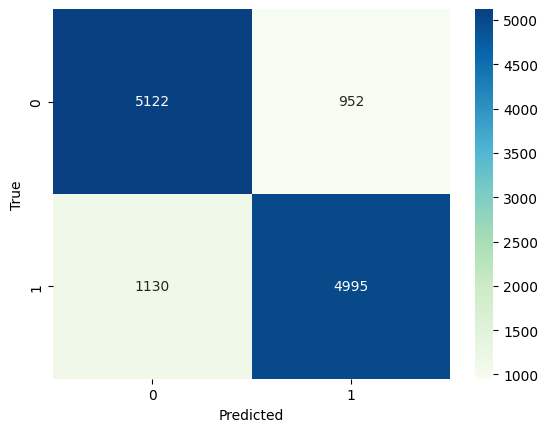

In [33]:
#Creo la matriz de confusión
tabla=confusion_matrix(y_test, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

Ahora mostramos los valores todas las métricas del arbol:

* `precision` es la proporción de verdaderos positivos (TP) sobre el total de predicciones positivas (TP + FP). En nuestro contexto, mide la capacidad del modelo para predecir correctamente la cantidad de reservas que fueron canceladas.

* `recall` es la proporción de verdaderos positivos (TP) sobre el total de muestras positivas en los datos (TP + FN). En nuestro caso, mide la capacidad del modelo para identificar correctamente la cantidad de reservas que no fueron canceladas.

* `f1-score` es la media armónica entre precisión y recall. Es una métrica que combina ambos valores en una sola medida, y se utiliza cuando se quiere equilibrar ambas medidas. En nuestro caso, nos enfocamos en optimizar esta métrica ya que reduce la cantidad de FP y FN.

* `accuracy` es la proporción de predicciones correctas (TP + TN) sobre el total de muestras (TP + FP + TN + FN). Mide la capacidad del modelo para predecir correctamente ambas clases. En nuestro caso, cuantas predicciónes correctas hicimos (predecir correctamente cuales reservas se cancelaron y cuales no sobre el total de registros)

In [34]:
#Calculo las métricas en el conjunto de evaluación
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,)
precision=precision_score(y_test,y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8293302729731945
Recall: 0.8155102040816327
Precision: 0.83991928703548
f1 score: 0.8275347912524852


Como conclusión, podemos ver que las métricas son muy similares a los valores obtenidos cuando validamos los mejores parámetros en random search, por lo tanto el modelo tiene una buena predicción tanto para el dataset de entrenamiento como con el de prueba.

Finalmente, graficamos una parte representativa del arbol (No más de 4 nodos)

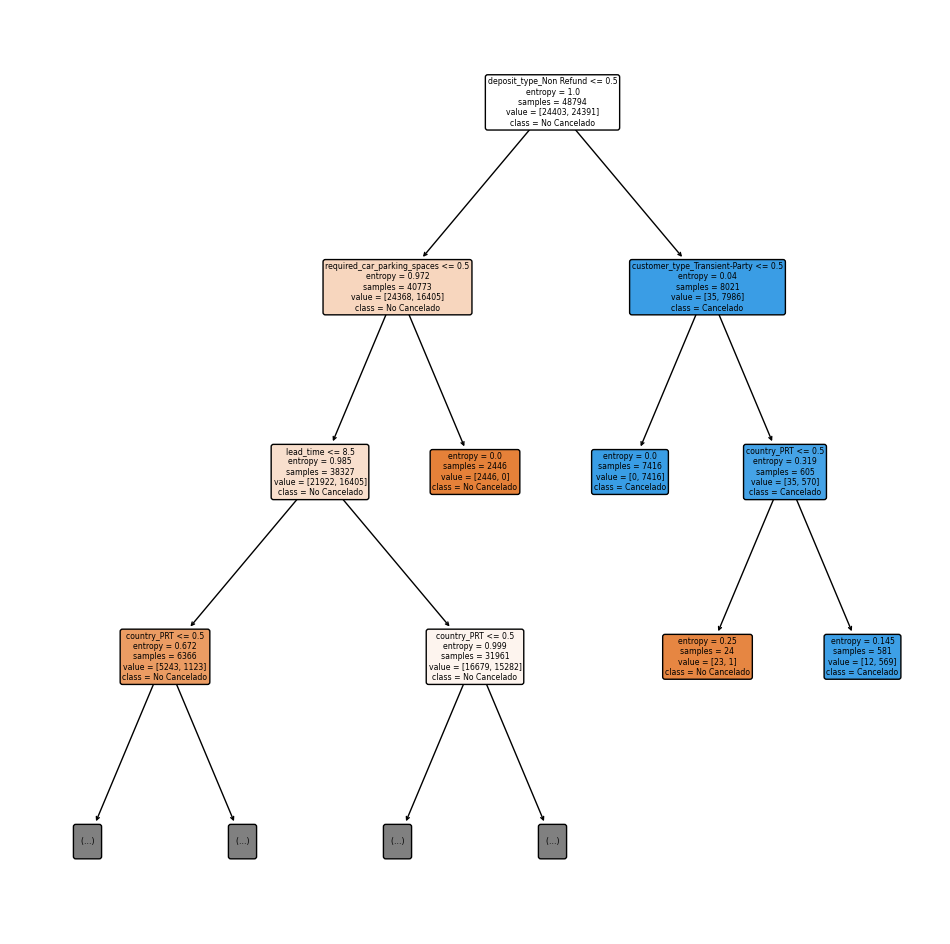

In [35]:
plt.figure(figsize=(12,12))

tree_plot=tree.plot_tree(model,
                         max_depth=3,
                         feature_names=ds_trabajo_x.columns.to_list(),
                         filled=True,
                         rounded=True,
                         class_names=['No Cancelado', 'Cancelado'])

plt.show(tree_plot)

## Entrenamos el arbol para la predicción de Kaggle

In [36]:
arbol_final=DecisionTreeClassifier().set_params(**randomcv.best_params_)

ds_trabajo_x = ds_trabajo_x.sort_index(axis=1, ascending=False)

#Entreno el arbol en todo el set
arbol_final.fit(ds_trabajo_x,ds_trabajo_y)

DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy', max_depth=13,
                       min_samples_leaf=4, min_samples_split=9)

In [37]:
ds_test_encoded = pd.get_dummies(dataset_test, columns=features, drop_first=True)

ds_test_x = ds_test_encoded.drop(['id'], axis='columns', inplace=False)

ds_test_x = ds_test_x.sort_index(axis=1, ascending=False)

# print(dataset.country.nunique())
# print(dataset_test.country.nunique())

print(ds_test_x.shape)
print(ds_trabajo_x.shape)

(26535, 67)
(60993, 67)


In [38]:
#Realizamos una predicción sobre el set de test
y_pred = arbol_final.predict(ds_test_x)
#Valores Predichos
y_pred

array([1, 1, 0, ..., 1, 1, 0])

In [39]:
# dataset_submit = dataset_test['id'].copy()
# dataset_submit['is_canceled'] = y_pred
dataset_submit = pd.DataFrame({'id': dataset_test.id, 'is_canceled': y_pred})
dataset_submit.head()

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,1
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1


In [40]:
#dataset_submit.to_csv('predict4.csv',index=False)

In [41]:
#joblib.dump(arbol_final, 'modelo.joblib')